# Lab 04: Mô hình hóa dữ liệu

* Họ và tên: Đinh Viết Lợi
* MSSV: 22120188

Mục lục bài làm
1. Tổng quan
2. Phân tích vấn đề
3. Tiền xử lý dữ liệu và phân chia tập train/test
4. Ứng dụng các mô hình
    - 4.1 
    - 4.2
    - 4.3
    - 4.4
    - 4.5
4. Đánh giá mô hình

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC  
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# Phần 1: Tổng quan
## Phần này nhằm nhắc lại một số nội dung về tập dữ liệu

Load dữ liệu

In [2]:
raw_white=pd.read_csv('data/winequality-white.csv',sep=';')
raw_red=pd.read_csv('data/winequality-red.csv',sep=';')

Gộp hai tập dữ liệu, đánh dấu loại rượu

In [3]:
raw_white['color']="white"
raw_red['color']="red"
raw_df=pd.concat([raw_white,raw_red],ignore_index=True)

Tiền xử lý loại bỏ các dòng trùng lặp

In [4]:
try:
    white_num_duplicated_rows=raw_white.duplicated().sum()
    red_num_duplicated_rows=raw_red.duplicated().sum()
except:
    raise NotImplementedError()

In [5]:
assert white_num_duplicated_rows == 937
assert red_num_duplicated_rows == 240

In [6]:
raw_red.drop_duplicates(keep=False, inplace=True)
raw_white.drop_duplicates(keep=False, inplace=True)
raw_df.drop_duplicates(keep=False, inplace=True)

Kiểm tra dữ liệu

In [7]:
print(raw_df.isna().sum())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
color                   0
dtype: int64


In [8]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4328 entries, 6 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4328 non-null   float64
 1   volatile acidity      4328 non-null   float64
 2   citric acid           4328 non-null   float64
 3   residual sugar        4328 non-null   float64
 4   chlorides             4328 non-null   float64
 5   free sulfur dioxide   4328 non-null   float64
 6   total sulfur dioxide  4328 non-null   float64
 7   density               4328 non-null   float64
 8   pH                    4328 non-null   float64
 9   sulphates             4328 non-null   float64
 10  alcohol               4328 non-null   float64
 11  quality               4328 non-null   int64  
 12  color                 4328 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 473.4+ KB


Ma trận tương quan giữa các thuộc tính

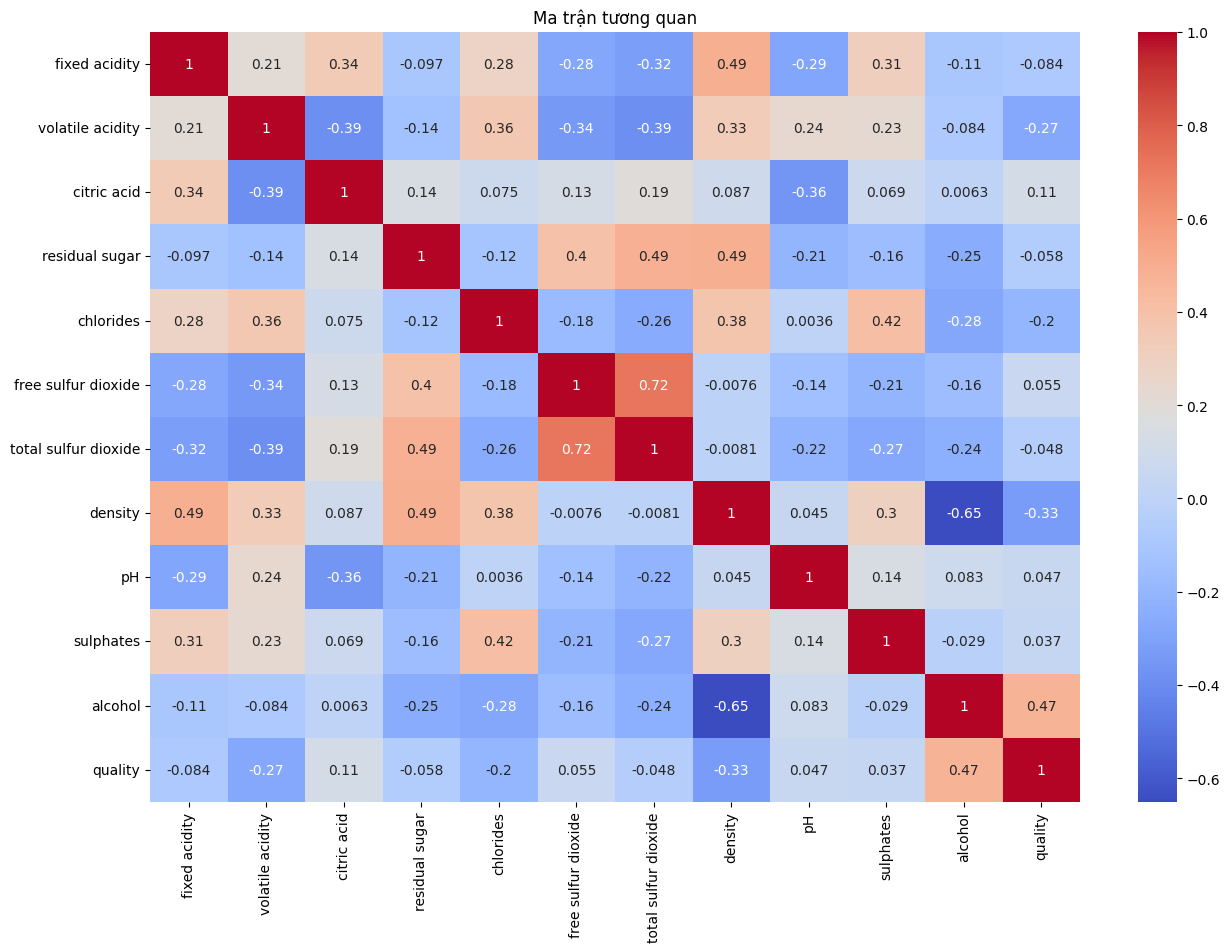

In [9]:
correlation = raw_df.drop(columns=['color']).corr()
plt.figure(figsize=(15,10))
sns.heatmap(correlation,annot=True, cmap='coolwarm')
plt.title('Ma trận tương quan')
plt.show()

# Phần 2: Phân tích bài toán

- Dựa theo bài khám phá dữ liệu, hai loại rượu không có quá nhiều sự khác biệt rõ rệt, tương quan giữa các thành phần không quá có sự khác biệt to lớn, số thuộc tính giống hệt nhau, kích thước bộ dữ liệu cũng không qua chênh lệch red/white=1/3 nên có thể gộp hai bộ thành 1 tập dữ liệu chung.
- Nội dung cần dự đoán là chất lượng của rượu, đây là nhãn của tập dữ liệu, có các giá trị rời rạc từ 1 đến 10 nên ta nên ưu tiên sử dụng các mô hình thuộc nhóm phân loại (classification).
- Tuy nhiên cần phân tích về bộ dữ liệu trước khi đưa vào huấn luyện, đặc biệt là để tránh bộ dữ liệu mất cân bằng

Khảo sát phân bố về mẫu rượu và chất lượng của chúng

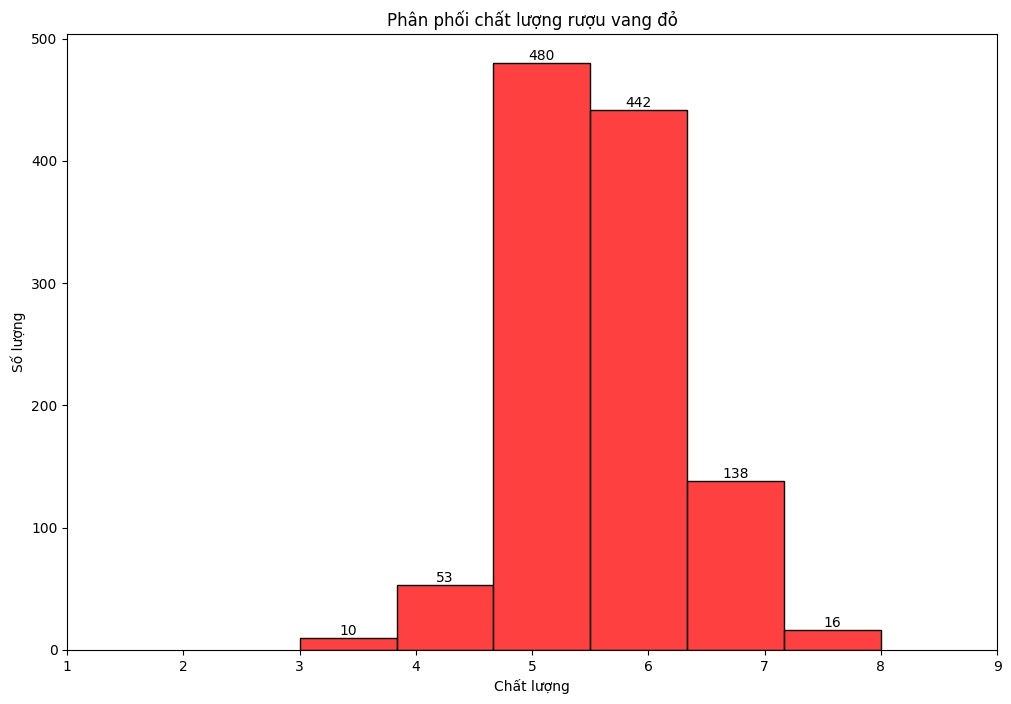

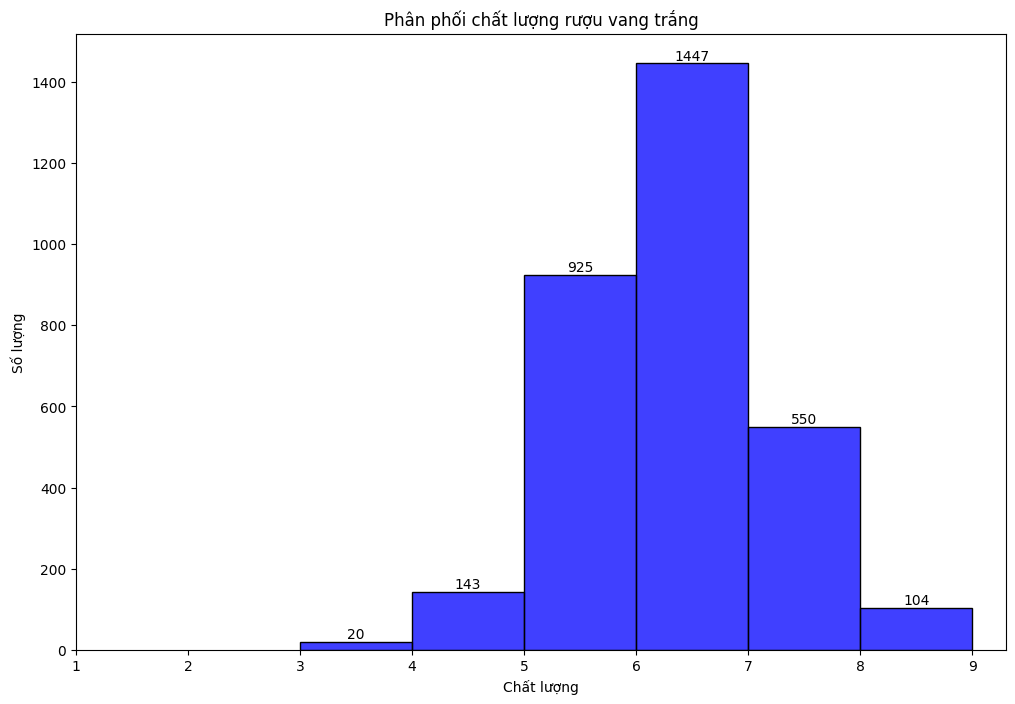

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

try:
    plt.figure(figsize=(12,8))
    ax=sns.histplot(raw_red['quality'], bins=6,color='red')
    #Thể hiện số lượng
    for p in ax.patches:
        count = int(p.get_height())  
        if count > 0:  
            x = p.get_x() + p.get_width() / 2  
            y = p.get_height() 
            ax.text(x, y, str(count), ha='center', va='bottom', fontsize=10)
            
    plt.title('Phân phối chất lượng rượu vang đỏ')
    plt.xlabel('Chất lượng')
    plt.ylabel('Số lượng')
    plt.xticks(np.arange(1, 10, 1))
    plt.show()
    
    plt.figure(figsize=(12,8))
    ax=sns.histplot(raw_white['quality'], bins=6,color='blue')
    #Thể hiện số lượng
    for p in ax.patches:
        count = int(p.get_height())  
        if count > 0:  
            x = p.get_x() + p.get_width() / 2  
            y = p.get_height() 
            ax.text(x, y, str(count), ha='center', va='bottom', fontsize=10)
            
    plt.title('Phân phối chất lượng rượu vang trắng')
    plt.xlabel('Chất lượng')
    plt.ylabel('Số lượng')
    plt.xticks(np.arange(1, 10, 1))
    plt.show()

except Exception as e:
    print(f"Error: {e}")
    raise NotImplementedError()


- Nhận xét:
    * Về số lượng mẫu rượu, tỉ lệ giữa vang đỏ và vang trắng là 1:3
    * Về chất lượng của từng mẫu, hầu hết các mẫu rượu đều nằm trong khoảng chất lượng từ 5-7 và giảm dần về hai bên, hầu như không có mẫu rượu nào có chất lượng 1 2 và 10.
- Kết luận:
    * Việc mất cân bằng về tập dữ liệu có thể gây khó khăn trong quá trình triển khai bộ máy học, tình trạng thể hiện rõ nhất ở đây là thiếu dữ liệu ở một số nhóm.
    * Để đảm bảo việc phân chia bộ dữ liệu hợp lý cần thực hiện hai công việc: đảm bảo tất cả các chất lượng rượu, màu rượu (red,white) đều được phân chia hợp lý vào bộ train,test và xử lý dữ liệu phân bố không cân bằng thông qua phương pháp Oversampling, Underspamling hoặc Class Weights.

# Phần 3: Tiền xử lý dữ liệu và phân chia tập train/test

## Đánh giá tập dữ liệu

**Vấn đề ngoại lai**: tham khảo từ HW03, tuy bộ dữ liệu có nhiều giá trị ngoại lai nhưng có thể chấp nhận được bởi các giá trị này được đánh giá riêng với từng mẫu rượu, ít khả năng là giá trị lỗi.

**Vấn đề loại màu rượu**: tập dữ liệu train/test nên bao gồm cả hai loại rượu nên có thể ghép hai tập dữ liệu lại với nhau sau khi phân chia tập train/test hợp lý mà không làm mất đi tỉ lệ số lượng mẫu mỗi loại. Đồng thời tỉ lệ này là 1:3 nên không gây mất cân bằng nặng.

**Mất cân bằng về từng mức chất lượng** : đây là nguyên nhân chính dẫn đến mức cân bằng tập dữ liệu, việc giải quyết sự mất cân bằng sẽ tập trung vào vấn đề này. Do kích thước tập dữ liệu không quá lớn, phương pháp SMOTE và Class weighting phù hợp trong trường hợp này

## Phân chia tập train/test

Phân chia tập dữ liệu vang đỏ

In [11]:

X_red=raw_red.drop(columns=['quality','color'])
y_red=raw_red['quality']
X_red=StandardScaler().fit_transform(X_red)
X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(X_red, y_red, test_size=0.2, random_state=42)
smote=SMOTE(random_state=42)
#smote = SMOTE(sampling_strategy={3: 100, 4: 125, 5: 390, 6: 390, 7: 250, 8: 100}, random_state=42)
X_train_red_smote, y_train_red_smote=smote.fit_resample(X_train_red,y_train_red)

Phân chia tập dữ liệu vang trắng

In [12]:
raw_white['quality'].value_counts()

quality
6    1447
5     925
7     550
4     143
8      99
3      20
9       5
Name: count, dtype: int64

Các mẫu vang đỏ có chất lượng 9 có số lượng quá ít (chỉ gồm 5 mẫu) nên việc giữ lại các mẫu này để dự đoán không đáng tin cây, đề xuất loại bỏ

In [15]:
raw_white=raw_white[raw_white['quality']!=9]

In [17]:
X_white=raw_white.drop(columns=['quality','color'])
y_white=raw_white['quality']
X_white=StandardScaler().fit_transform(X_white)
X_train_white, X_test_white, y_train_white, y_test_white = train_test_split(X_white, y_white, test_size=0.2, random_state=42)
#smote = SMOTE(sampling_strategy={3: 368, 4: 722, 5: 1195, 6: 1326, 7: 924, 8: 673}, random_state=42)
smote=SMOTE(random_state=42)
X_train_white_smote, y_train_white_smote=smote.fit_resample(X_train_white,y_train_white)

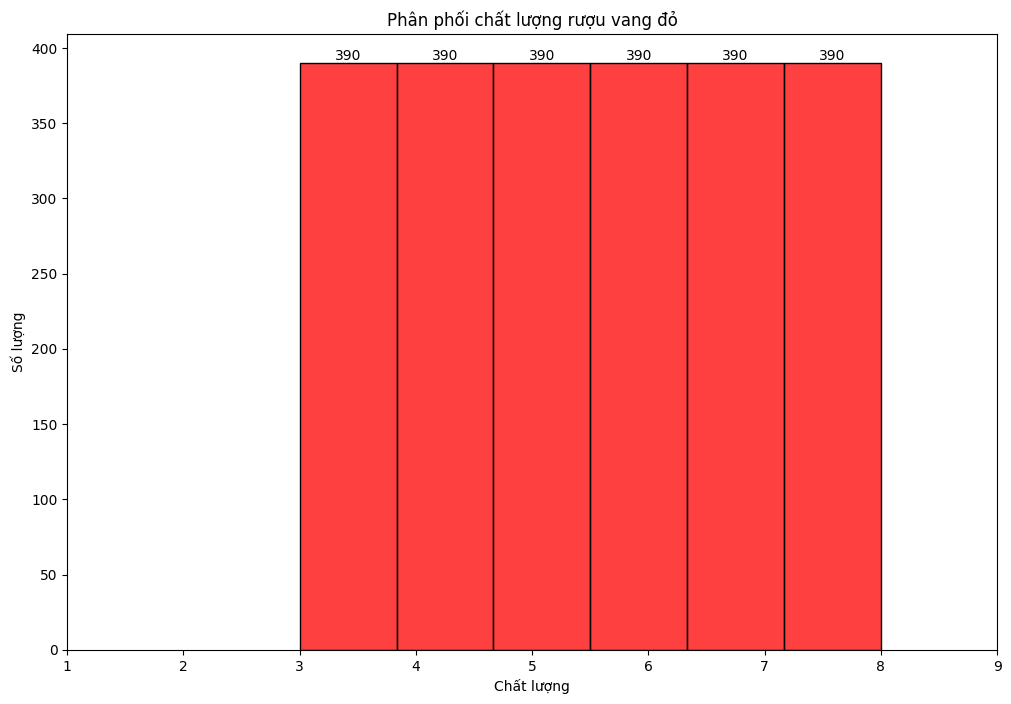

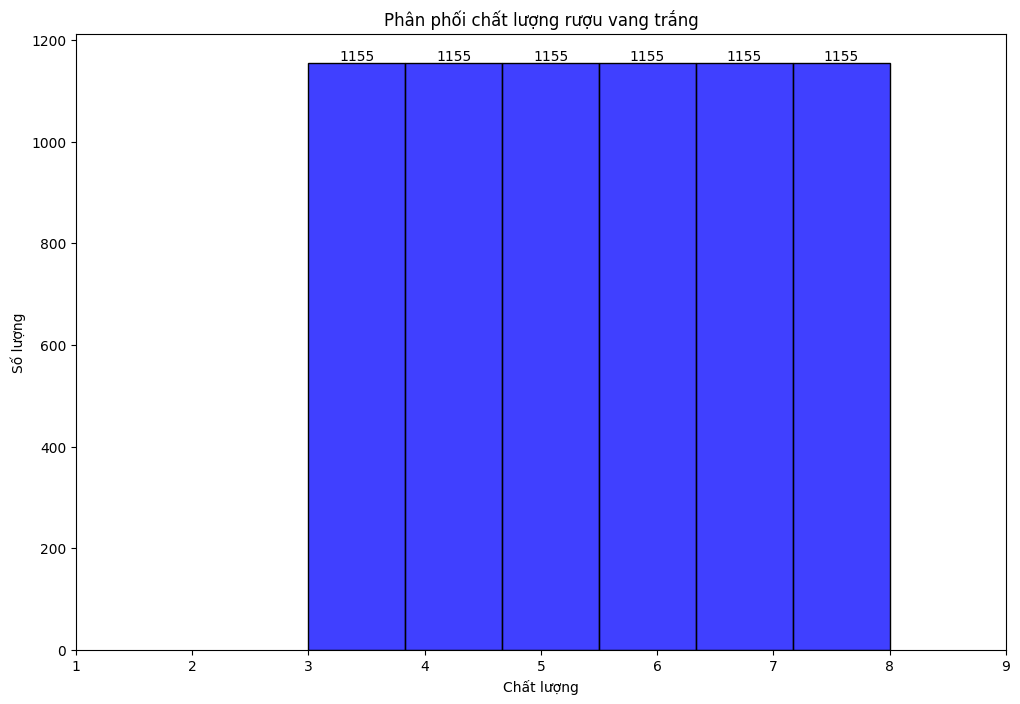

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

try:
    plt.figure(figsize=(12,8))
    ax=sns.histplot(y_train_red_smote, bins=6,color='red')
    #Thể hiện số lượng
    for p in ax.patches:
        count = int(p.get_height())  
        if count > 0:  
            x = p.get_x() + p.get_width() / 2  
            y = p.get_height() 
            ax.text(x, y, str(count), ha='center', va='bottom', fontsize=10)
            
    plt.title('Phân phối chất lượng rượu vang đỏ')
    plt.xlabel('Chất lượng')
    plt.ylabel('Số lượng')
    plt.xticks(np.arange(1, 10, 1))
    plt.show()
    
    plt.figure(figsize=(12,8))
    ax=sns.histplot(y_train_white_smote, bins=6,color='blue')
    #Thể hiện số lượng
    for p in ax.patches:
        count = int(p.get_height())  
        if count > 0:  
            x = p.get_x() + p.get_width() / 2  
            y = p.get_height() 
            ax.text(x, y, str(count), ha='center', va='bottom', fontsize=10)
            
    plt.title('Phân phối chất lượng rượu vang trắng')
    plt.xlabel('Chất lượng')
    plt.ylabel('Số lượng')
    plt.xticks(np.arange(1, 10, 1))
    plt.show()

except Exception as e:
    print(f"Error: {e}")
    raise NotImplementedError()


Gom hai bộ dữ liệu lại

In [19]:
# Red is 0, White is 1
X_train_white_smote=pd.DataFrame(X_train_white_smote,columns=raw_white.drop(columns=['quality','color']).columns)
X_train_white_smote['color']=0
X_train_red_smote=pd.DataFrame(X_train_red_smote,columns=raw_red.drop(columns=['quality','color']).columns)
X_train_red_smote['color']=1
X_train=pd.concat([X_train_red_smote,X_train_white_smote],ignore_index=True)

X_test_white=pd.DataFrame(X_test_white,columns=raw_white.drop(columns=['quality','color']).columns)
X_test_white['color']=0
X_test_red=pd.DataFrame(X_test_red,columns=raw_red.drop(columns=['quality','color']).columns)
X_test_red['color']=1
X_test=pd.concat([X_test_red,X_test_white],ignore_index=True)

y_train=pd.concat([y_train_red_smote,y_train_white_smote],ignore_index=True)
y_test=pd.concat([y_test_red,y_test_white],ignore_index=True)


Kết quả trước khi phân chia

In [20]:
raw_red['quality'].value_counts()
raw_white['quality'].value_counts()

quality
6    1447
5     925
7     550
4     143
8      99
3      20
Name: count, dtype: int64

Kết quả sau khi phân chia

In [21]:
X_train['color'].value_counts()

color
0    6930
1    2340
Name: count, dtype: int64

In [22]:
y_train.value_counts()

quality
7    1545
5    1545
6    1545
3    1545
4    1545
8    1545
Name: count, dtype: int64

In [23]:
X_test['color'].value_counts()

color
0    637
1    228
Name: count, dtype: int64

In [24]:
y_test.value_counts()

quality
6    373
5    269
7    149
4     41
8     24
3      9
Name: count, dtype: int64

# 3. Ứng dụng các mô hình

## 3.1 Mô hình Random Forest

In [25]:
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20, 30]
# }
# grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
# grid_search.fit(X_train, y_train)

# # Mô hình tốt nhất
# best_model = grid_search.best_estimator_


In [28]:
from sklearn.model_selection import GridSearchCV

# Tạo grid các tham số để tìm kiếm
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Sử dụng GridSearchCV để tìm tham số tốt nhất
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Mô hình tốt nhất
best_model = grid_search.best_estimator_

# Dự đoán trên tập test với mô hình tốt nhất
y_pred = best_model.predict(X_test)

# Đánh giá mô hình
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print(f"Best model parameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


c:\Users\vietl\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
460 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\vietl\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\vietl\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\vietl\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\bas

Best model parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Accuracy: 0.5133
Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         9
           4       0.33      0.49      0.40        41
           5       0.54      0.61      0.57       269
           6       0.58      0.49      0.53       373
           7       0.49      0.49      0.49       149
           8       0.10      0.12      0.11        24

    accuracy                           0.51       865
   macro avg       0.34      0.37      0.35       865
weighted avg       0.52      0.51      0.51       865

Confusion Matrix:
[[  0   2   6   1   0   0]
 [  1  20  13   5   2   0]
 [  2  24 164  73   6   0]
 [  2  12 111 184  53  11]
 [  0   2   7  50  73  17]
 [  0   0   1   6  14   3]]


Confusion Matrix:
 [[  0   2   7   0   0   0]
 [  1  19  13   6   2   0]
 [  2  28 167  64   8   0]
 [  1  16 109 181  55  11]
 [  0   1   9  54  70  15]
 [  0   0   0   9  13   2]]
Accuracy Score: 0.507514450867052
Classification Report:
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         9
           4       0.29      0.46      0.36        41
           5       0.55      0.62      0.58       269
           6       0.58      0.49      0.53       373
           7       0.47      0.47      0.47       149
           8       0.07      0.08      0.08        24

    accuracy                           0.51       865
   macro avg       0.33      0.35      0.34       865
weighted avg       0.52      0.51      0.51       865

